## High level PyTorch  
### _Introduction to Neural Network_

So far we've been dealing with low-level torch API. While it's absolutely vital for any custom losses or layers, building large neura nets in it is a bit clumsy.

Luckily, there's also a high-level torch interface with a pre-defined layers, activations and training algorithms. 

We'll cover them as we go through a simple image recognition problem: classifying handwritten digits.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from IPython.display import clear_output

In [2]:
path = "/home/mohammadreza/share/data"
ds_train = MNIST(path, train=True, download=False)
ds_test = MNIST(path, train=False, download=False)

/home/mohammadreza/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
X_train, y_train = ds_train.data.reshape(-1, 784).to(torch.float32) / 255., ds_train.targets
X_test, y_test = ds_test.data.reshape(-1, 784).to(torch.float32) / 255., ds_test.targets

clear_output()
print(f"Trian size = {len(X_train)}, test_size = {len(X_test)}")

Trian size = 60000, test_size = 10000


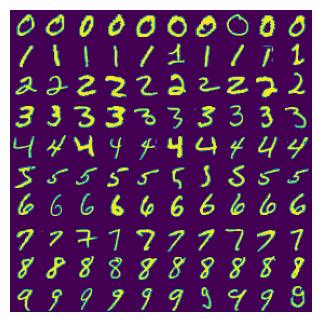

In [4]:
plt.figure(figsize=(4, 4), dpi=100)
plt.axis('off')
plt.imshow(
    torch.transpose(
        torch.cat(
            [X_train[y_train == c][:10] for c in range(10)], axis=0
        ).reshape(10, 10, 28, 28),
        1, 2
    ).reshape(280, 280)
);

In [5]:
from torch import nn
import torch.nn.functional as F

There's a vast library of popular layers and architectures already built for ya'.

We'll train a single hidden layer fully connected neural network. First, let's see whether GPU is available 

In [6]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2021-08-13 21:09:30.522159: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


['/device:CPU:0']


2021-08-13 21:09:32.773698: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-13 21:09:32.777293: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-13 21:09:32.805732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-13 21:09:32.806669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 0.8605GHz coreCount: 4 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 37.33GiB/s
2021-08-13 2

In [7]:
# GPU support 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
torch.cuda.is_available()

True

In [9]:
#create a network that stacks layers on top of each other 
#Fully Connected Layers -> Linear layers .
#Linear(input:size of images we have, output:output on stack on the hidden layer)
model = nn.Sequential(
      nn.Linear(784, 100), # add first dense layer with 784 input units and 100 output 
      # (100  is somehow hyperparameter)
      nn.ReLU(), # Activation layer (Non-linear and elementwise function) 
      # Dense layer (Linear) + Activation layer (relu) ==> Hidden layer 
      nn.Linear(100, 10) # Dense layer with 10 output -> number of the classes
      # We do not use probability function (like softmax) here , since we want just logits.
).to(device)


In [10]:
# Checking what parameters our model has

print("Weight shapes: ")
  
'''
  [100, 784] => parameters of the first layer 
  ReLU activation does not have parameters, it is jus a fixed function
  [100] => Bias vector. As we had in linear models, we do not just calculate the w*x, we also 
  have bias terms. Similarly, this is for neural network as well.  the size of
  this vector is the size of of hidden state which is 100 here. So far we have :
  ReLU(w * x + b)
  First two refer to first linear layer
  last two are the parametres of the second linear layer
'''
for w in model.parameters():
      print(" ", w.shape)


Weight shapes: 
  torch.Size([100, 784])
  torch.Size([100])
  torch.Size([10, 100])
  torch.Size([10])


In [11]:
# now we can simply call it on our data to get the model output:
prediction = model(X_train.to(device))
prediction.shape

torch.Size([60000, 10])

In [12]:
loss_func = nn.CrossEntropyLoss()  
# It has softmax() inside, therefore we did not use Softmax() activation in the last layer. 
# If we use it, the loss function would be "NLLLOSS (Negative Log Likelihood)".
'''
"LOSS FUNCTIONS"
Cross-Entropy: calculates the average difference between the predicted and 
  actual probabilities
Hinge : It penalizes the model when there is a difference in the sign between
  the actual and predicted class values.
Kullback Leibler Divergence: calculates how much a given distribution is away
  from the true distribution. These are used to carry out complex operations like
  autoencoder where there is a need to learn the dense feature representation.

'''
print(loss_func(prediction, y_train.to(device)))

tensor(2.3020, device='cuda:0', grad_fn=<NllLossBackward>)


In [13]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
prediction

tensor([[ 0.0634,  0.0618,  0.1358,  ..., -0.0422, -0.0460, -0.0438],
        [ 0.0496,  0.0341,  0.1467,  ...,  0.0036, -0.0416, -0.0337],
        [-0.0177, -0.0292,  0.1390,  ..., -0.0207, -0.1541, -0.0043],
        ...,
        [ 0.0935,  0.0671,  0.0973,  ..., -0.0299,  0.0186,  0.0064],
        [ 0.0289,  0.0070,  0.2565,  ...,  0.0878, -0.1525, -0.0309],
        [ 0.0911,  0.0003,  0.1528,  ...,  0.0121, -0.0708,  0.0549]],
       device='cuda:0', grad_fn=<AddmmBackward>)

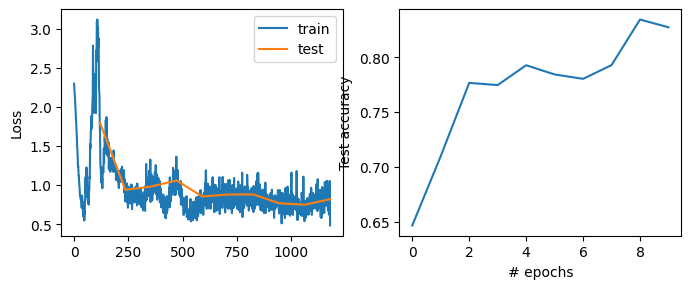

In [15]:
from tqdm import trange # Utility function to show progress bar

num_epochs = 10
batch_size =512

# plottting quatities 
train_losses = []
test_losses = []
test_accuracy = []

# epoch = one pass through the dataset

for i_epoch in range(num_epochs):
    
    shuffle_ids = np.random.permutation(len(X_train))
    for idx in trange(0, len(X_train), batch_size):
        
    # Get the next batch of the data
        batch_X = X_train[shuffle_ids][idx : idx + batch_size].to(device)
        batch_y = y_train[shuffle_ids][idx : idx + batch_size].to(device)

    # Typical codes for implementing the loss and optimization
        loss = loss_func(model(batch_X), batch_y) # (prediction, y_train)
        loss.backward() # Evaluating the gradient of loss
        opt.step()
        opt.zero_grad

    # remember the loss value at this step
        train_losses.append(loss.item())

  #evaluate test loss and metrics

    test_prediction = model(X_test.to(device)) # type -> Probability
  #test_loss = loss_func(test_prediction, y_test.to(device))
  #test_losses.append(test_loss.item())
  # Or
    test_losses.append(
      loss_func(test_prediction, y_test.to(device)).item()
    )
    test_accuracy.append(
      (test_prediction.argmax(axis=1) == y_test.to(device)).to(float).mean()
    )
  

  # all the following simply is just for plotting

    clear_output(wait=True)

    plt.figure(figsize=(8, 3), dpi=100)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(
        np.linspace(0, len(train_losses), len(test_losses) + 1)[1:],
        test_losses, label='test'
    )

    plt.ylabel("Loss")

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracy)
    plt.ylabel("Test accuracy")
    plt.xlabel("# epochs")
    plt.show()

In [16]:
test_accuracy

[tensor(0.6466, device='cuda:0', dtype=torch.float64),
 tensor(0.7098, device='cuda:0', dtype=torch.float64),
 tensor(0.7766, device='cuda:0', dtype=torch.float64),
 tensor(0.7746, device='cuda:0', dtype=torch.float64),
 tensor(0.7927, device='cuda:0', dtype=torch.float64),
 tensor(0.7843, device='cuda:0', dtype=torch.float64),
 tensor(0.7803, device='cuda:0', dtype=torch.float64),
 tensor(0.7928, device='cuda:0', dtype=torch.float64),
 tensor(0.8344, device='cuda:0', dtype=torch.float64),
 tensor(0.8273, device='cuda:0', dtype=torch.float64)]

In [ ]:
model2 = nn.Sequential(
    nn.Linear(784, 250),
    nn.ReLU(),
    nn.Linear(250, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
).to(device)

In [ ]:
for w in model2.parameters():
  print("The wieght shape is:", w.shape)

In [ ]:
prediction2 = model2(X_train.to(device))
print(loss_func(prediction2, y_train.to(device)))

In [ ]:
opt = torch.optim.Adam(model2.parameters(), lr=1e-4)

In [ ]:
test_accuracy

## XOR problem